## Keyphrase extraction from sociology papers
This notebook contains the efforts to extract crucial n-grams identifying the concept of Nation from some sociology papers published between the end of the 20th century and the beginning of the 21st century. The papers are in French (11 papers) and in German (4 papers)

In [1]:
# imports
import pandas as pd
import glob
from nltk.corpus import stopwords
import nltk 
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import spacy
import json
from PIL import Image
import wordcloud

In [3]:
#loading the data
french_txt = []

for file in glob.glob("data_sociology/french*.txt"):
    print(file)
    french_txt.append(open(file, "r", encoding='utf8').read())
    
german_txt = []

for file in glob.glob("data_sociology/german*.txt"):
    german_txt.append(open(file, "r", encoding='utf8').read())
    
print(len(french_txt), len(german_txt))

data_sociology\french-Babadzan.txt
data_sociology\french-DIECKHOFF.txt
data_sociology\french-gellner.txt
data_sociology\french-GODECHOT.txt
data_sociology\french-Hermet.txt
data_sociology\french-Ipperciel-2.txt
data_sociology\french-Ipperciel.txt
data_sociology\french-Ledermann.txt
data_sociology\french-racisme.txt
data_sociology\french-renans-rev.txt
data_sociology\french-swiss-nationality.txt
11 4


In [4]:
#loading the data
french_baseline = []
for file in glob.glob("baseline_sociology/french*.txt"):
    french_baseline.append(open(file, "r", encoding='utf8').read())
    
german_baseline = []

for file in glob.glob("baseline_sociology/german*.txt"):
    german_baseline.append(open(file, "r", encoding='utf8').read())
    
print(len(french_baseline), len(german_baseline))

11 4


### Preprocessing
- punctuation removal
- stopword removal
- (OPTIONAL) language filtering
- lemmatization
- part-of-speech tagging filtering

In [5]:
#english_vocab = set(w.lower() for w in nltk.corpus.words.words())
#text_vocab = set(w.lower() for w in ' '.join(french_txt+german_txt).split() if w.lower().isalpha())
#unusual = text_vocab.intersection(english_vocab)
#unusual.add('cookies')
#len(unusual)

In [6]:
#! python -m spacy download de_core_news_sm
#! python -m spacy download fr_core_news_sm

In [7]:
pos_to_keep = ['ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB']

french_txt_sw = []
french_baseline_sw = []

tokenizer = nltk.RegexpTokenizer(r"\w+")

#load spacy corpuses
nlp_de = spacy.load('de_core_news_sm')
nlp_fr = spacy.load('fr_core_news_sm')

def lematization_pos_tagging(tagging_language_funtion, text):
    doc = tagging_language_funtion(text)
    lemmatized = [x.lemma_ for x in doc if x.pos_ in pos_to_keep and x.is_stop != True]
    return lemmatized

for i in range(len(french_txt)):
    print(i)
    if len(french_txt[i])< 100000:
        text_tokens = lematization_pos_tagging(nlp_fr, french_txt[i])
    else:
        text_tokens = lematization_pos_tagging(nlp_fr, french_txt[i][:99999])
    french_txt_sw.append(' '.join(text_tokens))
    text_tokens = lematization_pos_tagging(nlp_fr, french_baseline[i])
    french_baseline_sw.append(' '.join(text_tokens))
    
        
    
german_txt_sw = []
german_baseline_sw = []

for i in range(len(german_txt)):
    print(i)
    text_tokens = lematization_pos_tagging(nlp_de, german_txt[i])
    german_txt_sw.append(' '.join(text_tokens))
    text_tokens = lematization_pos_tagging(nlp_de, german_baseline[i])
    german_baseline_sw.append(' '.join(text_tokens))
    
print(french_txt_sw[0][:20], '\n', german_txt_sw[0][:20])

0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
invention tradition  
 Nationalismus Nation


In [8]:
str_french = ' '.join(french_txt_sw)
french = french_baseline_sw + [str_french]
len(french)
str_german = ' '.join(german_txt_sw)
german = german_baseline_sw + [str_german]
len(german)

5

In [9]:
len(french[11])

378494

for the future: stemming part of speech tagging and do with adjectives more texts more preprocessing in general LDA

### Frequent n-gram extraction

In [40]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(french[:12])
df_tfidf = pd.DataFrame(X.toarray())
swiss_tfidf = df_tfidf[df_tfidf.index==11]
swiss_tfidf= swiss_tfidf.T.sort_values(by=11, ascending=False)


swiss_indexes = swiss_tfidf.index
feature_names = vectorizer.get_feature_names()
term_list = [feature_names[i] for i in swiss_indexes]
print(term_list[:100])

['nationalisme', 'nationalité', 'nation', 'racisme', 'suisse', 'convention', 'droit', 'etat', 'national', 'politique', 'patrie', 'anderson', 'smith', 'culture', 'tradition', 'culturel', 'peuple', 'nationaliste', 'hobsbawm', 'voir', 'naturalisation', 'nairn', 'habermas', 'nationaliter', 'social', 'nationalism', 'langue', 'moderne', 'europe', 'patriote', 'gellner', 'renan', 'homme', 'mot', 'principe', 'phénomène', 'linguistique', 'art', 'question', 'citoyen', 'pouvoir', 'rapport', 'patriotisme', 'naim', 'public', 'sens', 'théoricien', 'inventer', 'sentiment', 'cas', 'théorie', 'grand', 'raison', 'populaire', 'également', 'état', 'société', 'communauté', 'lien', 'général', 'pays', 'européen', 'fédéral', 'individu', 'ethnique', 'étude', 'unité', 'chapitre', 'forme', 'alémanique', 'romand', 'faire', 'nouveau', 'auteur', 'idée', 'siècle', 'mettre', 'empire', 'canton', 'identité', 'définition', 'ensemble', 'origine', 'international', 'débat', 'travail', 'français', 'populisme', 'souveraineté'

nationalisme     0.527218
nationalité      0.315846
nation           0.249201
racisme          0.225824
suisse           0.193941
                   ...   
impersonnelle    0.000000
impartialit      0.000000
immerg           0.000000
immatériel       0.000000
intrusion        0.000000
Name: 11, Length: 15626, dtype: float64


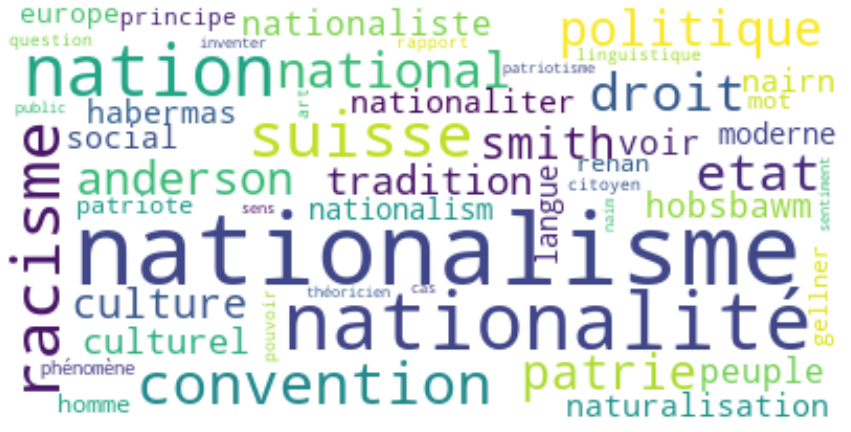

In [42]:
dense = X.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).T.sort_values(by=11, ascending=False)
print(df[11])
Cloud = wordcloud.WordCloud(background_color="white", max_words=50).generate_from_frequencies(df[11][:50])
fig, ax = plt.subplots(figsize=(15, 18))
ax.imshow(Cloud, interpolation='bilinear')
#plt.tight_layout()
plt.axis('off')
plt.show()

In [11]:
# Selected words:
#for word in term_list[:50]:
#    print(word)

In [12]:
def raw2counts(df):
    df = pd.DataFrame(df.data.values[0]).set_index("label")["items"].apply(pd.Series).stack().reset_index().drop("level_1", axis=1)
    df.columns = ["label", "data"]
    df = pd.concat([df, df["data"].apply(pd.Series)], axis=1).drop("data", axis=1)
    return df

In [13]:
# impresso results
trends_french = pd.read_json('./unigrams/unigrams_sociology_french.json', lines=True)
trends_french = raw2counts(trends_french)
trends_french = trends_french.groupby(pd.to_datetime(trends_french.date).dt.year//10).sum().reset_index()
trends_french

,date,value,total,ppm
0,179,4895,25056350,19272.765953
1,180,15504,84269750,56194.808633
2,181,30678,160446250,96612.938391
3,182,43328,249419900,85888.240482
4,183,58091,309818100,93452.545525
5,184,61981,335378650,92190.863623
6,185,115109,584440400,98162.554051
7,186,209072,972409050,107391.548531
8,187,274476,1362793850,100923.352667
9,188,329905,1657365600,99467.407131


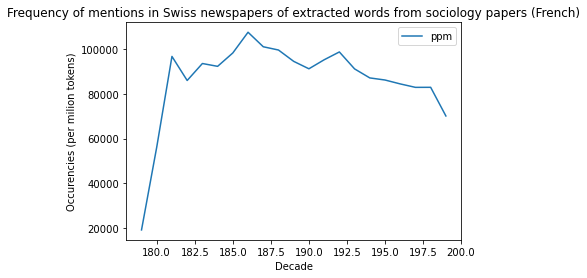

In [14]:
ax = trends_french.plot(x='date', y='ppm')
ax.set_ylabel("Occurencies (per milion tokens)")
ax.set_xlabel("Decade")
ax.set_title("Frequency of mentions in Swiss newspapers of extracted words from sociology papers (French)")
plt.savefig("french.png", dpi=600)

In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(german)
df_tfidf = pd.DataFrame(X.toarray())
swiss_tfidf = df_tfidf[df_tfidf.index==4]
swiss_tfidf=swiss_tfidf.T.sort_values(by=4, ascending=False)


swiss_indexes = swiss_tfidf.index
feature_names = vectorizer.get_feature_names()
term_list = [feature_names[i] for i in swiss_indexes]
print(term_list[:100])

['nation', 'nationalstaat', 'deutsch', 'nationalismus', 'national', 'europa', 'politisch', 'schweiz', 'staat', 'österreich', 'revolution', 'deutschland', 'jahrhundert', 'volk', 'nationsbildung', '19', 'geschichte', 'politische', 'reich', 'jahn', 'einheit', 'sängerbewegung', 'entstehen', 'krieg', 'schwäbisch', 'fremde', 'frankreich', 'europäisch', 'kulturell', 'gesellschaft', 'preuße', 'idee', 'deutsche', 'leben', 'bund', 'turnbewegung', 'lassen', 'modern', 'schweizer', 'alt', 'verein', 'turner', 'grenze', 'land', 'bewegung', 'müssen', 'gemeinsam', 'bilden', 'bleiben', 'ziel', 'nationalbewegung', 'stadt', 'gelten', 'zeigen', 'gehören', 'fest', 'schaffen', 'historisch', 'entwicklung', 'staatlich', 'preußisch', 'sprechen', 'sozial', 'mitglied', 'kraft', 'mensch', 'zuvor', 'gott', 'prozeß', 'territorium', 'militärisch', 'sänger', 'stark', 'stellen', 'tragen', 'kampf', 'weltkrieg', 'gegenwart', 'neu', 'nennen', 'bestimmen', 'religiös', 'vergangenheit', 'vorstellung', 'stehen', 'europäische'

In [16]:
# Selected words:

#for word in term_list[:50]:
#    print(word)

In [17]:
# impresso results
trends_german = pd.read_json('./unigrams/unigrams_sociology_german.json', lines=True)
trends_german = raw2counts(trends_german)
trends_german = trends_german.groupby(pd.to_datetime(trends_german.date).dt.year//10).sum().reset_index()
trends_german

,date,value,total,ppm
0,178,29304,179905950,81352.067508
1,179,31677,237189450,68261.433197
2,180,39999,245521250,81506.761070
3,181,33054,262613250,63268.949410
4,182,56945,405449750,68578.008136
5,183,94567,578287200,81871.770549
6,184,181857,876938000,101745.382768
7,185,266305,1449802450,92648.625931
8,186,355508,2635705900,69161.918467
9,187,703363,4611242950,76917.515716


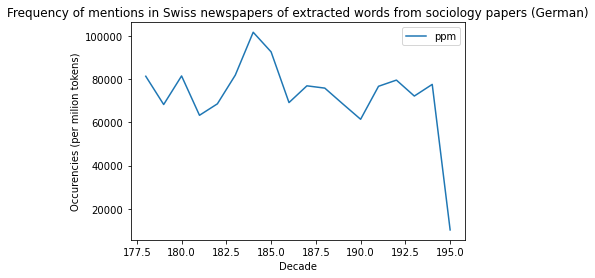

In [18]:
ax = trends_german.plot(x='date', y='ppm')
ax.set_ylabel("Occurencies (per milion tokens)")
ax.set_xlabel("Decade")
ax.set_title("Frequency of mentions in Swiss newspapers of extracted words from sociology papers (German)")
plt.savefig("german.png", dpi=600)

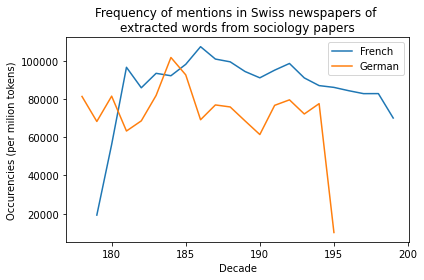

In [39]:
ax = trends_french.plot(x='date', y='ppm', label='French')
trends_german.plot(x='date', y='ppm', label='German', ax=ax)
ax.set_ylabel("Occurencies (per milion tokens)")
ax.set_xlabel("Decade")
ax.set_title("Frequency of mentions in Swiss newspapers of \nextracted words from sociology papers")

plt.tight_layout()
plt.savefig("both.png", dpi=600)

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(2,4))
X = vectorizer.fit_transform(french[:12])
df_tfidf = pd.DataFrame(X.toarray())
swiss_tfidf = df_tfidf[df_tfidf.index==11]
swiss_tfidf= swiss_tfidf.T.sort_values(by=11, ascending=False)


swiss_indexes = swiss_tfidf.index
feature_names = vectorizer.get_feature_names()
term_list = [feature_names[i] for i in swiss_indexes]
mapping = {}
for i,f_name in enumerate(feature_names):
    mapping[i] = f_name
print(term_list[:200])

['racisme nationalisme', 'droit nationalité', 'théorie nationalisme', 'convention nationalité', 'théoricien nationalisme', 'tradition inventer', 'convention européen', 'droit homme', 'art convention', 'nationalisme racisme', 'mot patrie', 'articulation racisme', 'articulation racisme nationalisme', 'lien racisme', 'lien racisme nationalisme', 'européen nationalité', 'invention tradition', 'convention européen nationalité', 'rapport explicatif convention', 'explicatif convention', 'art let', 'naturalisation ordinaire', 'explicatif convention européen', 'rapport explicatif', 'nationalité droit', 'rapport explicatif convention européen', 'nation moderne', 'nationalité numéro', 'mot nation', 'droit international', 'convention européen nationalité numéro', 'anthony smith', 'relation racisme', 'droit fondamental', 'européen nationalité numéro', 'explicatif convention européen nationalité', 'espace public', 'let convention', 'art convention nationalité', 'procédure naturalisation', 'batiffol 

In [21]:
dense = X.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).T.sort_values(by=11, ascending=False)
print(df[11])

racisme nationalisme                 0.250101
droit nationalité                    0.135189
théorie nationalisme                 0.110405
convention nationalité               0.087873
théoricien nationalisme              0.083367
                                       ...   
impossible thi content               0.000000
impossible thi content downloaded    0.000000
impostur scientifique                0.000000
impostur scientifique constitue      0.000000
légitimer voir                       0.000000
Name: 11, Length: 260254, dtype: float64


In [22]:
Cloud = wordcloud.WordCloud(background_color="white", max_words=50).generate_from_frequencies(df[11][:50])

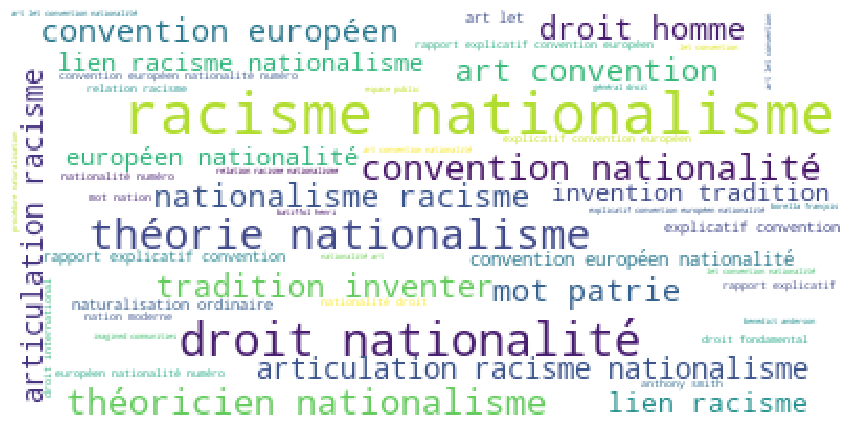

In [31]:
# display the word cloud
fig, ax = plt.subplots(figsize=(15, 18))
ax.imshow(Cloud, interpolation='bilinear')
#plt.tight_layout()
plt.axis('off')
plt.show()

In [32]:
vectorizer = TfidfVectorizer(ngram_range=(2,4))
X = vectorizer.fit_transform(german)
df_tfidf = pd.DataFrame(X.toarray())
swiss_tfidf = df_tfidf[df_tfidf.index==4]
swiss_tfidf=swiss_tfidf.T.sort_values(by=4, ascending=False)


swiss_indexes = swiss_tfidf.index
feature_names = vectorizer.get_feature_names()
term_list = [feature_names[i] for i in swiss_indexes]
print(term_list[:200])

['deutsch nation', '19 jahrhundert', 'deutsch nationalstaat', 'deutsche bund', 'deutsch staat', 'nation nationalstaat', 'deutsch geschichte', 'hälfte 19 jahrhundert', 'modern nationalismus', 'hälfte 19', 'schwäbisch sängerbewegung', 'deutsch nationalbewegung', '18 jahrhundert', 'prozeß nationsbildung', 'idee nation', 'schwäbische sängerbewegung', 'national bewegung', 'modern nation', '20 jahrhundert', 'französische revolution', 'alte reich', 'deutsch sängerbewegung', 'schwäbisch sängerbund', 'schwäbische sängerbundes', 'deutsch volk', 'spät 18', 'idee deutsch', 'partizipation aggression', 'kleindeutschen nationalstaat', 'staat gesellschaft', 'otto elben', '19 20', 'sozial bewegung', 'karl pfaff', 'frage stellen', 'mehrheits minderheitenspannungen', 'deutsch kulturnation', 'einzeln staat', 'deutsch nationalismus', 'gründung nationalstaat', 'nation nationalismus', '19 20 jahrhundert', 'innen außen', 'staat deutsche', 'spät 18 jahrhundert', 'weimarer republik', 'europäisch staat', 'deutsc

deutsch nation                            0.190400
19 jahrhundert                            0.187914
deutsch nationalstaat                     0.110231
deutsche bund                             0.100210
deutsch staat                             0.085179
                                            ...   
nehmen programmatik soziologie private    0.000000
nehmen programmatik soziologie            0.000000
nehmen programmatik                       0.000000
nehmen karl popper ausdrücken             0.000000
lebensführung soziologie                  0.000000
Name: 4, Length: 143428, dtype: float64


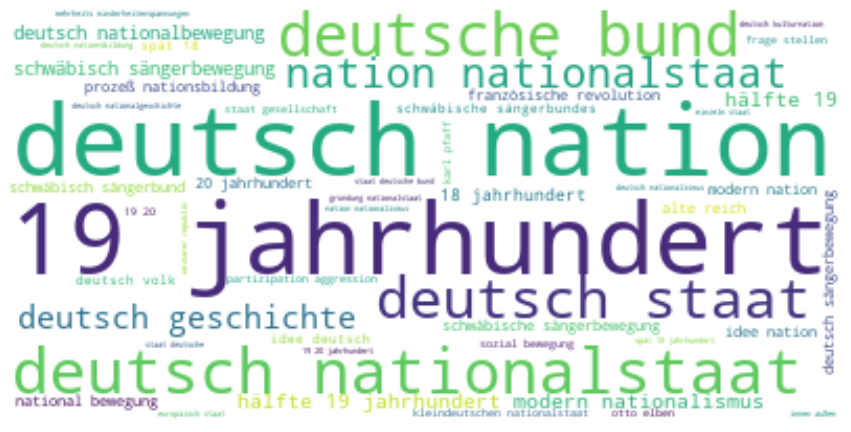

In [35]:
dense = X.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).T.sort_values(by=4, ascending=False)
print(df[4])
Cloud = wordcloud.WordCloud(background_color="white", max_words=50).generate_from_frequencies(df[4][:50])
fig, ax = plt.subplots(figsize=(15, 18))
ax.imshow(Cloud, interpolation='bilinear')
#plt.tight_layout()
plt.axis('off')
plt.show()

In [36]:
# only swiss vs general nationality          
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(french_txt_sw[:11])
df_tfidf = pd.DataFrame(X.toarray())
swiss_tfidf = df_tfidf[df_tfidf.index==10]
swiss_tfidf= swiss_tfidf.T.sort_values(by=10, ascending=False)


swiss_indexes = swiss_tfidf.index
feature_names = vectorizer.get_feature_names()
term_list = [feature_names[i] for i in swiss_indexes]
print(term_list[:100])

['nationalité', 'convention', 'droit', 'etat', 'art', 'naturalisation', 'suisse', 'nationaliter', 'numéro', 'international', 'voir', 'infra', 'fédéral', 'matière', 'paul', 'françois', 'cour', 'également', 'chapitre', 'européen', 'procédure', 'acquisition', 'général', 'apatridie', 'henri', 'ordinaire', 'domaine', 'traité', 'prévoir', 'recueil', 'juridique', 'rs', 'let', 'explicatif', 'batiffol', 'compétence', 'monsieur', 'relatif', 'homme', 'étranger', 'avril', 'règle', 'borella', 'citoyenneté', 'entrer', 'cas', 'lagarde', 'perte', 'obligation', 'rapport', 'théorie', 'titre', 'militaire', 'conseil', 'ratifier', 'rezek', 'immer', 'décembre', 'haye', 'francisco', 'décision', 'vigueur', 'johannes', 'ressortissant', 'protocole', 'tribunal', 'réglementation', 'chan', 'apatride', 'disposition', 'loi', 'coutumier', 'terme', 'principe', 'pierre', 'vol', 'femme', 'jacques', 'roland', 'hélène', 'weis', 'alexander', 'kotalakidi', 'enfant', 'justice', 'condition', 'national', 'manière', 'josé', 'lé

nationalité    0.574741
convention     0.323441
droit          0.303851
etat           0.170644
art            0.167201
                 ...   
fon            0.000000
fomenter       0.000000
foll           0.000000
folkloriste    0.000000
œuvrer         0.000000
Name: 10, Length: 9594, dtype: float64


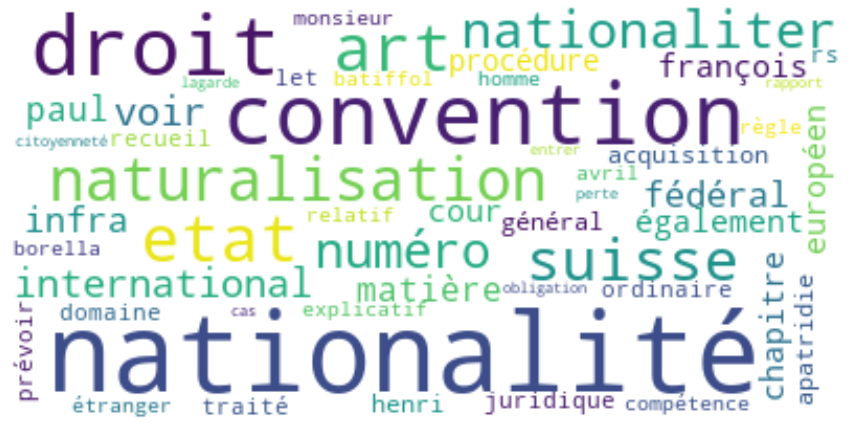

In [37]:
dense = X.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).T.sort_values(by=10, ascending=False)
print(df[10])
Cloud = wordcloud.WordCloud(background_color="white", max_words=50).generate_from_frequencies(df[10][:50])
fig, ax = plt.subplots(figsize=(15, 18))
ax.imshow(Cloud, interpolation='bilinear')
#plt.tight_layout()
plt.axis('off')
plt.show()

### Other plots

In [ ]:
french_bigrams = (pd.Series(nltk.ngrams(' '.join(french_txt_sw).split(), 2)).value_counts())[:30]
french_trigrams = (pd.Series(nltk.ngrams(' '.join(french_txt_sw).split(), 3)).value_counts())[:30]

In [ ]:
french_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

In [ ]:
french_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

In [ ]:
german_bigrams = (pd.Series(nltk.ngrams(' '.join(german_txt_sw).split(), 2)).value_counts())[:40]
german_trigrams = (pd.Series(nltk.ngrams(' '.join(german_txt_sw).split(), 3)).value_counts())[:35]

In [ ]:
german_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

In [ ]:
german_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

### Trying out some LDA to get only words related to topic nationality

In [ ]:
french_tokens = [tokenizer.tokenize(french) for french in french_txt_sw]
# Create Dictionary
id2word = corpora.Dictionary(french_tokens)
# Create Corpus
texts = french_tokens
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

In [ ]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

In [ ]:
for index, topic in lda_model.show_topics(formatted=False, num_words=40):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))

In [ ]:
german_tokens = [tokenizer.tokenize(german) for german in german_txt_sw]
# Create Dictionary
id2word = corpora.Dictionary(german_tokens)
# Create Corpus
texts = german_tokens
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

In [ ]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

In [ ]:
for index, topic in lda_model.show_topics(formatted=False, num_words=40):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))